# Download the Data

In [1]:
!pip3 install tqdm
!pip3 install pillow --upgrade

In [2]:
%matplotlib inline

import os
import io
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

urls = ['https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

Already downloaded https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Already downloaded https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


# Visualize Data

In [3]:
trimaps_dir = 'data/annotations/trimaps/'

maps = [x for x in os.listdir(trimaps_dir) if x[-3:] == 'png']
print(len(maps))

14780


In [4]:
image_dir = 'data/images/'

images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

7390


In [5]:
images[0]

'Russian_Blue_194.jpg'

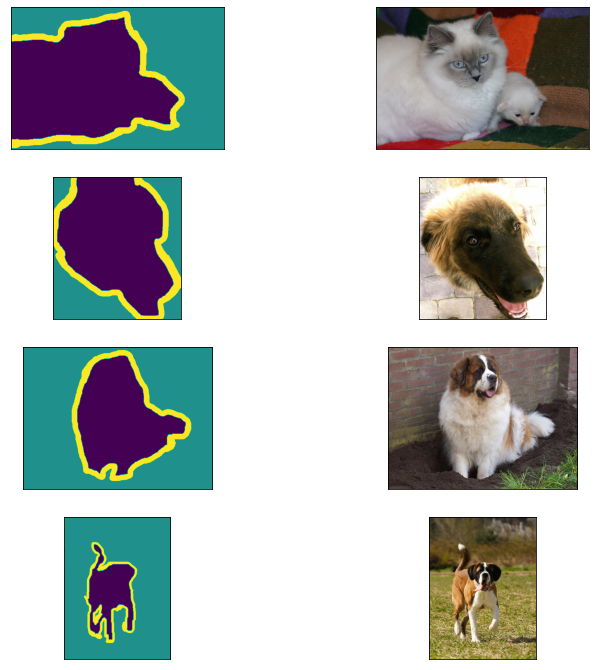

In [6]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_name = images[index]
    map_name = images[index].split('.')[0] + '.png'

    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(trimaps_dir, map_name)))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(image_dir, image_name)))
plt.show()

In [7]:
img = Image.open(os.path.join(trimaps_dir, maps[0]))
print(np.unique(img))

[1 2 3]


# SageMaker Setup

In [8]:
role = sagemaker.get_execution_role()
bucket_name = 'oxfordpetsdata'
#training_image = get_image_uri(boto3.Session().region_name, 'semantic-segmentation', 
                              #repo_version='latest')

training_image = sagemaker.image_uris.retrieve('semantic-segmentation', region=boto3.Session().region_name, 
                                               version='latest')
print(training_image)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


825641698319.dkr.ecr.us-east-2.amazonaws.com/semantic-segmentation:1


In [9]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [10]:
def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file
    
for image in tqdm(images):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    
    image_file_path = os.path.join('data/images/', image)
    image_target_path = os.path.join(target_set, image)
    
    map_file_path = os.path.join(trimaps_dir, get_map_file(image))
    map_target_path = os.path.join(target_set + '_annotation', get_map_file(image))
    
    shutil.copy(image_file_path, image_target_path)
    shutil.copy(map_file_path, map_target_path)

100%|██████████| 7390/7390 [00:18<00:00, 396.18it/s]


In [11]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [12]:
print(len(train_annots), len(train_images))

5603 5603


# Uploading Data to S3

In [13]:
sess = sagemaker.Session()
print('Starting Upload')
s3_train_path = sess.upload_data(path='train', bucket=bucket_name, key_prefix='train')
print('Training Images Uploaded')
s3_train_annotation_path = sess.upload_data(path='train_annotation', bucket=bucket_name, 
                                            key_prefix='train_annotation')


print('Training Annontations Uploaded')
s3_validation_path = sess.upload_data(path='validation', bucket=bucket_name, key_prefix='validation')
print('Validation Images Uploaded')
s3_validation_annotation_path = sess.upload_data(path='validation_annotation', bucket=bucket_name, 
                                            key_prefix='validation_annotation')
print('Validation Annotations Uploaded')

Starting Upload
Training Images Uploaded
Training Annontations Uploaded
Validation Images Uploaded
Validation Annotations Uploaded


In [14]:
s3_validation_annotation_path

's3://oxfordpetsdata/validation_annotation'

# SageMaker Estimator

In [15]:
model = sagemaker.estimator.Estimator(
    training_image,
    role = role,
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    volume_size=100,
    max_run=36000,
    input_mode='File',
    output_path='s3://oxfordpetsdata/output',
    sagemaker_session=sess)

In [16]:
model

# Hyperparameters

In [18]:
model.set_hyperparameters(
    backbone='resnet-50',
    algorithm='fcn',
    use_pretrained_model=True,
    crop_size=240,
    num_classes=4,
    epochs=10,
    learning_rate=0.0001,
    optimizer='rmsprop',
    lr_scheduler='poly',
    mini_batch_size=16,
    validation_mini_batch_size=16,
    num_training_samples=len(train_images)
    
)

# Data Channels

In [19]:
train_data = sagemaker.inputs.TrainingInput(s3_train_path, distribution='FullyReplicated',
                                       content_type='image/jpeg', s3_data_type='S3Prefix')

validation_data = sagemaker.inputs.TrainingInput(s3_validation_path, distribution='FullyReplicated',
                                       content_type='image/jpeg', s3_data_type='S3Prefix')

train_annotation_data = sagemaker.inputs.TrainingInput(s3_train_annotation_path, distribution='FullyReplicated',
                                       content_type='image/png', s3_data_type='S3Prefix')

validation_annotation_data = sagemaker.inputs.TrainingInput(s3_validation_annotation_path, distribution='FullyReplicated',
                                       content_type='image/png', s3_data_type='S3Prefix')

In [20]:
data_channel = {
    'train': train_data,
    'validation':validation_data,
    'train_annotation': train_annotation_data,
    'validation_annotation':validation_annotation_data
}

In [21]:
data_channel

{'train': <sagemaker.inputs.TrainingInput at 0x7f35f887f0b8>,
 'validation': <sagemaker.inputs.TrainingInput at 0x7f35f887f3c8>,
 'train_annotation': <sagemaker.inputs.TrainingInput at 0x7f35f89dc3c8>,
 'validation_annotation': <sagemaker.inputs.TrainingInput at 0x7f35f89dc438>}

# Model Training

In [ ]:
model.fit(inputs=data_channel, logs=True)

2021-03-17 18:31:35 Starting - Starting the training job...
2021-03-17 18:31:58 Starting - Launching requested ML instancesProfilerReport-1616005894: InProgress
......
2021-03-17 18:32:59 Starting - Preparing the instances for training.....
2021-03-17 18:33:59 Downloading - Downloading input data.[03/17/2021 19:00:16 INFO 140499886765248] #progress_notice. epoch: 5, iterations: 420 speed: 91.5676938359 samples/sec
[03/17/2021 19:00:19 INFO 140499886765248] #quality_metric. host: algo-1, epoch: 5, validation pixel_accuracy: 0.9286322289958365 .
[03/17/2021 19:00:19 INFO 140499886765248] #quality_metric. host: algo-1, epoch: 5, validation mIOU: 0.6082283732955267 .
[03/17/2021 19:00:19 INFO 140499886765248] #throughput_metric. host: algo-1, epoch: 5, validation throughput: 87.4914353777 samples/sec.
[03/17/2021 19:00:19 INFO 140499886765248] Serializing model to /opt/ml/model/model_best.params
[03/17/2021 19:00:19 INFO 140499886765248] #progress_metric: host=algo-1, completed 60 % of epo

# Deploy Model

In [23]:
deployed_model = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print('\nModel Deployed!')

---------------!
Model Deployed!


# Predictions

In [24]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

1787


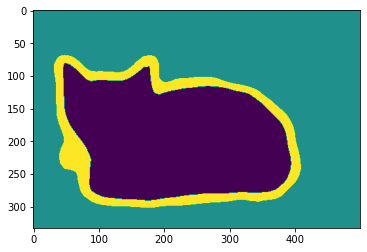

In [28]:
from PIL import Image
import numpy as np

class ImageDeserializer(sagemaker.deserializers.BaseDeserializer):
    """Deserialize a PIL-compatible stream of Image bytes into a numpy pixel array"""
    def __init__(self, accept="image/png"):
        self.accept = accept

    @property
    def ACCEPT(self):
        return (self.accept,)

    def deserialize(self, stream, content_type):
        """Read a stream of bytes returned from an inference endpoint.
        Args:
            stream (botocore.response.StreamingBody): A stream of bytes.
            content_type (str): The MIME type of the data.
        Returns:
            mask: The numpy array of class labels per pixel
        """
        try:
            return np.array(Image.open(stream))
        finally:
            stream.close()


deployed_model.deserializer = ImageDeserializer(accept="image/png")
deployed_model.serializer = sagemaker.serializers.IdentitySerializer('image/jpeg')


image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']

index = 1

image_path = os.path.join(image_dir, images[index])

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

prediction = deployed_model.predict(b)

plt.imshow(prediction);


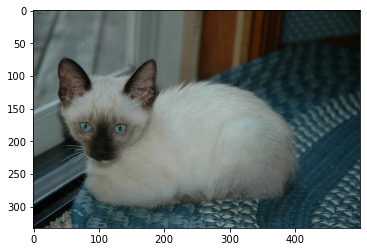

In [29]:
plt.imshow(plt.imread(image_path));

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [40]:
sagemaker.predictor.Predictor.delete_endpoint(deployed_model, delete_endpoint_config=True)